In [1]:
!pip install torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 10.8 MB/s eta 0:00:00


In [2]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset,DataLoader
import os
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from skimage import color
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch.optim.lr_scheduler as lr_scheduler
from torcheval.metrics.functional import multiclass_f1_score

In [3]:
root_dir = '/kaggle/input/malevis-train-dataset/malevis_train_val_224x224'
BATCH_SIZE = 32
epochs = 25

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
class MalevisDataset(Dataset):
    def __init__(self,root_dir,split = 'train',transform=None):
        self.root_dir = root_dir
        self.train_path = '/kaggle/input/malevis-train-dataset/malevis_train_val_224x224/train'
        self.val_path = '/kaggle/input/malevis-train-dataset/malevis_train_val_224x224/val'
        self.split = split
        self.transform = transform
        self.classes, self.class_to_idx = self.load_classes()
        self.images = self.load_images()
        
    def load_classes(self):
        if self.split == 'train':
            classes_path = os.path.join(self.root_dir, self.train_path)
        else:
            classes_path = os.path.join(self.root_dir, self.val_path)
            
        classes = [c for c in os.listdir(classes_path)]
        classes.sort()
        class_to_idx = {cls:i for i,cls in enumerate(classes)}
         
        return classes,class_to_idx
      
    def load_images(self):
        images = []
        
        for class_name in self.classes:
            if self.split=='train':
                for img in os.listdir(os.path.join(self.train_path,class_name)):
                    images.append((os.path.join(self.train_path,class_name,img),self.class_to_idx[class_name]))
            else:
                for img in os.listdir(os.path.join(self.val_path,class_name)):
                    images.append((os.path.join(self.val_path,class_name,img),self.class_to_idx[class_name]))
        
        return images
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self,idx):
        img_path , label = self.images[idx]
        img = mpimg.imread(img_path)
        img = color.rgb2gray(img)
        img = torch.from_numpy(img).to(torch.float32)
        if self.transform:
            img = self.transform(img)
#         img = torch.permute(img,(2,0,1))
        return img, label
    
        

In [6]:
train_data = MalevisDataset(root_dir=root_dir,
                           split='train')
test_data = MalevisDataset(root_dir=root_dir,
                           split='val')

In [7]:
# Building torch.utils.data.DataLoader

train_dataloader= DataLoader(dataset = train_data,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            drop_last=True)

test_dataloader= DataLoader(dataset = test_data,
                            batch_size=BATCH_SIZE,
                            shuffle=False,
                            drop_last=True) 

In [8]:
next(iter(train_dataloader))[0].shape

torch.Size([32, 224, 224])

In [9]:
len(train_dataloader)*32,len(test_dataloader)*32

(9088, 5120)

In [10]:
# Model Class

class Malware_Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 10, kernel_size = 5,stride =1,padding =2),
            nn.ReLU(),
            nn.Conv2d(in_channels = 10, out_channels = 10, kernel_size = 5,stride =1,padding =2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.25),
            nn.BatchNorm2d(10)
            )
        
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels = 10, out_channels = 10, kernel_size = 5,stride =1,padding =2),
            nn.ReLU(),
            nn.Conv2d(in_channels = 10, out_channels = 10, kernel_size = 5,stride =1,padding =2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.25),
            nn.BatchNorm2d(10)
            )
        
        self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=31360, out_features=256),# Adjust the number of neurons as needed
        nn.ReLU(),
        nn.Linear(in_features=256, out_features= 26)
        )

    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
#         print('Shape after first conv block:',x.shape)
        x = self.conv_block_2(x)
#         print('Shape after second conv block:',x.shape)
#         x = self.dropout(x)
        x = self.classifier(x)
        
#         print('Shape after linear block:', x.shape)
        return x


In [11]:
model = Malware_Classifier().to(device)

In [12]:
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params = model.parameters(),
                             lr = 0.001,weight_decay =0.001)

def accuracy_fn(y_true , y_pred):
    correct = torch.eq(y_true , y_pred).sum().item()
    percent = (correct/len(y_pred))*100
    return percent

In [13]:
#Training and testing loop
from tqdm import tqdm
torch.manual_seed(42)


for epoch in tqdm(range(epochs)):
    train_loss=0
    train_acc = 0
    train_f1_score = 0 
    for i, data in enumerate(train_dataloader):
        X_train,y_train = data
        X_train = torch.unsqueeze(X_train,dim=1)
        X_train,y_train = X_train.to(device),y_train.to(device)
        model.train()
        y_preds = model(X_train).to(device)
        
        loss = loss_fn(y_preds, y_train)
        
        train_loss+=loss
        
        train_f1_score += multiclass_f1_score(y_train, y_preds.argmax(dim=1).to(device), num_classes=26,average='macro')
        train_acc+=accuracy_fn(y_train, y_preds.argmax(dim=1).to(device))

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
                
    train_loss/=len(train_dataloader)
    train_acc/=len(train_dataloader)
    train_f1_score/= len(train_dataloader)
    print(f"Train Loss:{train_loss} | Train Accuracy: {train_acc} | Train F1_Score: {train_f1_score}")
    
    test_loss = 0
    test_acc = 0
    test_f1_score = 0
    
    model.eval()
    with torch.inference_mode():
        for X_test,y_test in test_dataloader:
            X_test = torch.unsqueeze(X_test,dim=1)
            X_test , y_test = X_test.to(device) , y_test.to(device)
            
            y_test_preds = model(X_test).to(device)
            test_loss+=loss_fn(y_test_preds, y_test)
            test_acc += accuracy_fn(y_test, y_test_preds.argmax(dim=1))
            test_f1_score += multiclass_f1_score(y_train, y_preds.argmax(dim=1).to(device), num_classes=26,average='macro')
       
            
        test_loss/=len(test_dataloader)
        test_acc/=len(test_dataloader)
        test_f1_score/=len(test_dataloader)
        print(f"Test Loss:{test_loss} | Test Accuracy: {test_acc}| Test F1_Score: {test_f1_score}")



  0%|          | 0/25 [00:00<?, ?it/s]

Train Loss:1.11964750289917 | Train Accuracy: 73.2394366197183 | Train F1_Score: 0.6572026014328003


  4%|▍         | 1/25 [02:42<1:04:57, 162.42s/it]

Test Loss:0.674761176109314 | Test Accuracy: 83.06640625| Test F1_Score: 0.7666682600975037
Train Loss:0.3422996997833252 | Train Accuracy: 90.55897887323944 | Train F1_Score: 0.8611921668052673


  8%|▊         | 2/25 [03:32<36:58, 96.47s/it]   

Test Loss:0.731791079044342 | Test Accuracy: 82.20703125| Test F1_Score: 0.7376407980918884
Train Loss:0.20571483671665192 | Train Accuracy: 93.89304577464789 | Train F1_Score: 0.9041846990585327


 12%|█▏        | 3/25 [04:22<27:32, 75.12s/it]

Test Loss:0.6903955936431885 | Test Accuracy: 83.671875| Test F1_Score: 0.9333341717720032
Train Loss:0.14288443326950073 | Train Accuracy: 95.79665492957747 | Train F1_Score: 0.9336168169975281


 16%|█▌        | 4/25 [05:16<23:19, 66.64s/it]

Test Loss:0.8268706202507019 | Test Accuracy: 80.33203125| Test F1_Score: 0.9233335852622986
Train Loss:0.12155124545097351 | Train Accuracy: 96.62191901408451 | Train F1_Score: 0.9472881555557251


 20%|██        | 5/25 [06:12<21:01, 63.06s/it]

Test Loss:0.8339671492576599 | Test Accuracy: 83.359375| Test F1_Score: 0.9216524362564087
Train Loss:0.12230836600065231 | Train Accuracy: 96.59991197183099 | Train F1_Score: 0.9449713230133057


 24%|██▍       | 6/25 [07:05<18:52, 59.61s/it]

Test Loss:0.7770340442657471 | Test Accuracy: 82.40234375| Test F1_Score: 1.0
Train Loss:0.11836555600166321 | Train Accuracy: 96.5118838028169 | Train F1_Score: 0.9432422518730164


 28%|██▊       | 7/25 [07:55<16:54, 56.39s/it]

Test Loss:0.8581011891365051 | Test Accuracy: 81.93359375| Test F1_Score: 1.0
Train Loss:0.09440210461616516 | Train Accuracy: 97.35915492957747 | Train F1_Score: 0.9564416408538818


 32%|███▏      | 8/25 [08:45<15:24, 54.37s/it]

Test Loss:0.8958669900894165 | Test Accuracy: 78.96484375| Test F1_Score: 0.9666658639907837
Train Loss:0.08626700192689896 | Train Accuracy: 97.32614436619718 | Train F1_Score: 0.9600550532341003


 36%|███▌      | 9/25 [09:35<14:10, 53.13s/it]

Test Loss:0.7956669926643372 | Test Accuracy: 83.61328125| Test F1_Score: 1.0
Train Loss:0.07451768964529037 | Train Accuracy: 97.71126760563381 | Train F1_Score: 0.9626810550689697


 40%|████      | 10/25 [10:25<13:01, 52.11s/it]

Test Loss:0.7795838117599487 | Test Accuracy: 82.8515625| Test F1_Score: 1.0
Train Loss:0.09472436457872391 | Train Accuracy: 97.37015845070422 | Train F1_Score: 0.9581013917922974


 44%|████▍     | 11/25 [11:16<12:04, 51.75s/it]

Test Loss:0.7564905285835266 | Test Accuracy: 83.75| Test F1_Score: 0.8511895537376404
Train Loss:0.09097250550985336 | Train Accuracy: 97.39216549295774 | Train F1_Score: 0.9564590454101562


 48%|████▊     | 12/25 [12:06<11:06, 51.30s/it]

Test Loss:0.7785349488258362 | Test Accuracy: 84.296875| Test F1_Score: 0.8392167091369629
Train Loss:0.056678496301174164 | Train Accuracy: 98.2394366197183 | Train F1_Score: 0.9720180630683899


 52%|█████▏    | 13/25 [12:57<10:13, 51.15s/it]

Test Loss:0.8030071258544922 | Test Accuracy: 84.47265625| Test F1_Score: 1.0
Train Loss:0.060310300439596176 | Train Accuracy: 98.22843309859155 | Train F1_Score: 0.9710410833358765


 56%|█████▌    | 14/25 [13:49<09:23, 51.20s/it]

Test Loss:0.7654776573181152 | Test Accuracy: 82.6953125| Test F1_Score: 1.0
Train Loss:0.07070352137088776 | Train Accuracy: 97.89832746478874 | Train F1_Score: 0.965650200843811


 60%|██████    | 15/25 [14:39<08:29, 50.92s/it]

Test Loss:0.7282217144966125 | Test Accuracy: 85.44921875| Test F1_Score: 0.9333341717720032
Train Loss:0.06936416029930115 | Train Accuracy: 98.04137323943662 | Train F1_Score: 0.9672187566757202


 64%|██████▍   | 16/25 [15:29<07:36, 50.71s/it]

Test Loss:0.8729648590087891 | Test Accuracy: 83.515625| Test F1_Score: 0.9682527780532837
Train Loss:0.06133421137928963 | Train Accuracy: 98.15140845070422 | Train F1_Score: 0.9709365963935852


 68%|██████▊   | 17/25 [16:19<06:44, 50.53s/it]

Test Loss:1.048385739326477 | Test Accuracy: 83.26171875| Test F1_Score: 0.971989631652832
Train Loss:0.06109199300408363 | Train Accuracy: 98.09639084507042 | Train F1_Score: 0.9683573246002197


 72%|███████▏  | 18/25 [17:10<05:53, 50.55s/it]

Test Loss:0.8419523239135742 | Test Accuracy: 83.984375| Test F1_Score: 0.9696961641311646
Train Loss:0.052267517894506454 | Train Accuracy: 98.39348591549296 | Train F1_Score: 0.975168764591217


 76%|███████▌  | 19/25 [18:00<05:03, 50.57s/it]

Test Loss:0.8340116739273071 | Test Accuracy: 84.16015625| Test F1_Score: 1.0
Train Loss:0.045573167502880096 | Train Accuracy: 98.7455985915493 | Train F1_Score: 0.9812787175178528


 80%|████████  | 20/25 [18:51<04:12, 50.44s/it]

Test Loss:0.9175570607185364 | Test Accuracy: 83.4375| Test F1_Score: 0.9365081191062927
Train Loss:0.06447828561067581 | Train Accuracy: 98.22843309859155 | Train F1_Score: 0.971299409866333


 84%|████████▍ | 21/25 [19:41<03:22, 50.52s/it]

Test Loss:0.6290972232818604 | Test Accuracy: 85.83984375| Test F1_Score: 1.0
Train Loss:0.062009502202272415 | Train Accuracy: 98.11839788732394 | Train F1_Score: 0.9728712439537048


 88%|████████▊ | 22/25 [20:31<02:31, 50.40s/it]

Test Loss:0.9701088070869446 | Test Accuracy: 81.46484375| Test F1_Score: 0.8888872265815735
Train Loss:0.05756010115146637 | Train Accuracy: 98.47051056338029 | Train F1_Score: 0.975642740726471


 92%|█████████▏| 23/25 [21:21<01:40, 50.24s/it]

Test Loss:0.9580694437026978 | Test Accuracy: 82.890625| Test F1_Score: 1.0
Train Loss:0.04139889031648636 | Train Accuracy: 98.81161971830986 | Train F1_Score: 0.9805956482887268


 96%|█████████▌| 24/25 [22:11<00:50, 50.20s/it]

Test Loss:0.8187553286552429 | Test Accuracy: 85.2734375| Test F1_Score: 0.9400011301040649
Train Loss:0.04094662517309189 | Train Accuracy: 98.72359154929578 | Train F1_Score: 0.9783140420913696


100%|██████████| 25/25 [23:01<00:00, 55.28s/it]

Test Loss:0.7848672270774841 | Test Accuracy: 85.1953125| Test F1_Score: 0.9111111760139465


In [14]:
def predict(model):
    fig = plt.figure(figsize=(15,10))
    rows = 3
    cols = 3
    
    for i in range(1,rows*cols+1):
        rand_idx = torch.randint(0,len(test_data),size=[1]).item()
        X_test,y_test = test_data[rand_idx]
        X_test= X_test.to(device)
        X_test = torch.unsqueeze(X_test,dim=0)
        X_test = torch.unsqueeze(X_test,dim=0)
        y_pred = model(X_test).to(device)
        y_pred_probs = torch.softmax(y_pred,dim=1)
        y_pred_label = torch.argmax(y_pred_probs,dim=1)
        fig.add_subplot(rows ,cols , i)

        plt.imshow(X_test.squeeze().squeeze().cpu().numpy(),cmap='gray')
        if(y_pred_label == y_test):
            plt.title(y_pred_label,color='g')
        else:
            plt.title(y_pred_label,color='r')
            

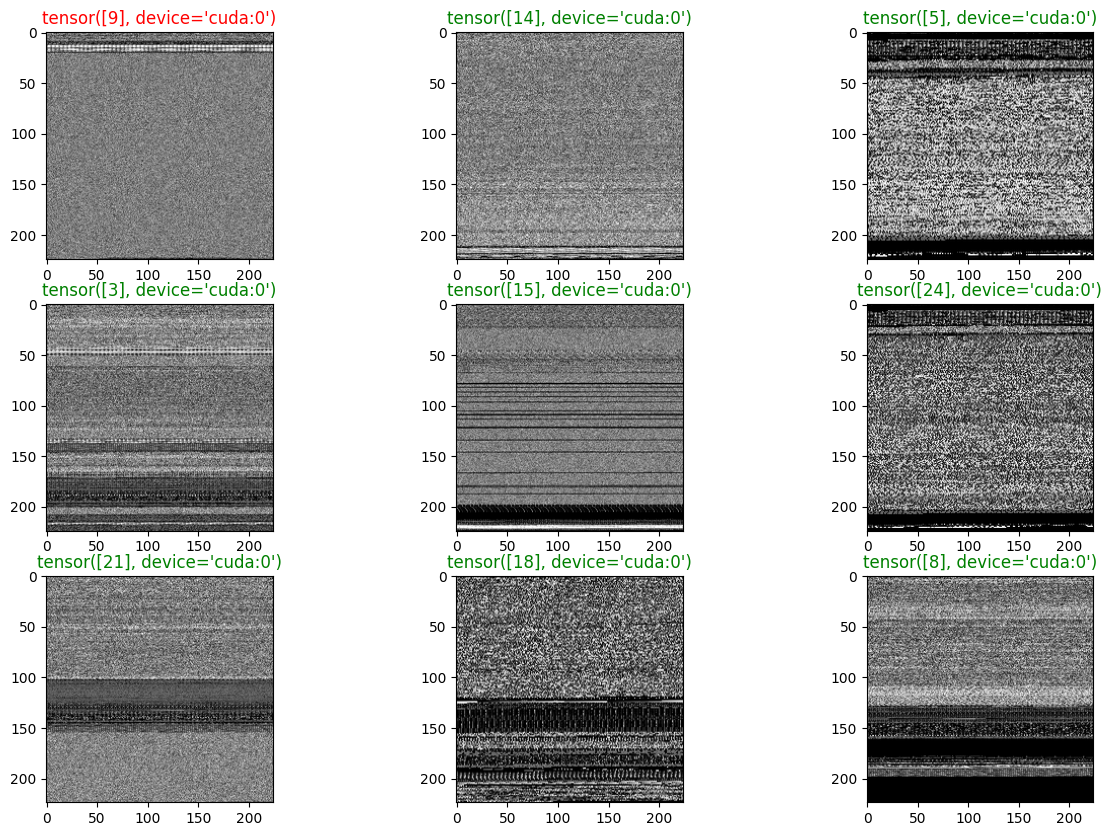

In [15]:
predict(model)
